# RES Forecasting - Wind Power Forecasting

The Greek RES dataset was created from a number of different sources, by combining energy generation, geolocation and weather data. The dataset contains geolocation, weather and RES energy production data of the top contributors of wind and solar energy that contribute the 20% of the RES power in the Greek energy grid. The weather data were collected from a weather forecast API and represent the last generated forecast for each installation.

The data were collected from the following sources:

* RES energy production from [ENTSO-E](https://transparency.entsoe.eu/load-domain/r2/totalLoadR2/show)
* Weather data captured using the [Stormglass API](https://docs.stormglass.io/#/weather?id=point-request)
* Wind turbine and PV installations geolocation data, for the locations that aquired operation licence as found in [Regulatory Authority for Energy (RAE)](https://geo.rae.gr/)

More information regarding energy licencing http://www.opengov.gr/minenv/?p=1031

The idea behind this exercise is to explore the predictability of the **wind energy production for the Greek energy grid** by using only aggregated weather information from the top 20% of wind park installations. The forecast horizon for this project is one week, and the predictions are performed by applying a rolling forecast with one day window and using as features *the next day's weather forecast* and *the previous day energy production*. Additionally, a number of temporal features are used as well, in an attemp to describe the seasonality of the timeseries. Features such as the *month, hour, day, day of week and day of year* are encoded with polar coordinates to capture their cyclical nature.


The study focuses on linear and non-linear statistical models and some hybrid combination of those
* Linear Regression
* Ridge Regression
* Elastic Net Regression
* Random Forest Regression
* Extreme Gradient Boosting
* Facebook Prophet
* Hybrid Facebook Prophet with Random Forest Regression
* Hybrid Facebook Prophet with Extreme Gradient Boosting


For the experiments, 4 years of weather and energy data were collected from 2017 to 2020. Namely, 5 different training and testing datasets have been developed, for each energy source, and the testing is applied on specific weeks of **March, May, July, October and December of 2020**. The forecast evaluation is perfoemed using MAE and RMSE as well as an error visualization using violin plots.

## 1. Introduction
### 1.1 Initialization

In [1]:
import json
import os
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import math
import geopandas as gpd
from shapely import wkt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
import seaborn as sns
sns.set_theme(style="white")
# sns.set()

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.inspection import permutation_importance

# Custom library that implements visualization fuctions and the rolling forecast
from helper_functions import ModelEvaluation 

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1.2 Greek Wind Park Installation Visualization

The geolocation data also contain information of the maximum energy capacity of each wind park installation. Using a violin plot for the distribution of the energy capacity, it becomes clear that it is heavily long-tailed distribution, which means that most of the energy generation capacity is contained in a small number of installations.

> Based on this long tail distribution, the hypothesis is borned that we can forecast the total wind energy production using aggregated weather information from the locations of the wind turbine installations of the top 20% wind energy contributors

In [2]:
# Load wind Data
geo_wind_df = pd.read_csv('data/Geolocation_data/V_SDI_R_AIOLIKA13.csv')
geo_wind_df.sort_values(by = 'power_mw', ascending=False, inplace=True)

geo_wind_df.loc[:, 'geometry'] = geo_wind_df['geometry'].apply(wkt.loads)

# Convert geo string to MultiPolygons
geo_wind_gdf = gpd.GeoDataFrame(geo_wind_df, geometry='geometry' )
# Get representative point for each polygon
geo_wind_gdf['representative_lon'] = geo_wind_gdf['geometry'].representative_point().x
geo_wind_gdf['representative_lat'] = geo_wind_gdf['geometry'].representative_point().y
geo_wind_gdf.shape

(316, 20)

Long tail distribution of the energy capacity of the licenced Wind Turbine installations in Greece

In [3]:
import plotly.express as px
fig = px.violin(x=geo_wind_gdf["power_mw"], 
          title='Distribution of the energy capacity of the licenced Wind Turbine installations in Greece', 
          box=True, # draw box plot inside the violin
          points='all')
fig.show()

A long tail distribution is observed in the wind power capacity data, meaning that most of the production is achieved by a small number of wind park installations. As seen below the 20% of the total wind power generation is produced by 18 wind park installations from a total of 316.

In [4]:
top_geo_wind_gdf = geo_wind_gdf[geo_wind_gdf['power_mw'].cumsum() < geo_wind_gdf['power_mw'].sum() * 20 / 100]
top_geo_wind_gdf.shape

(18, 20)

### 1.3 Greek Wind Park Installations Map
Wind turbine installations in Greece and the top 20% contributors

In [5]:
# Loading map config
with open('map_config/wind_map_config.json', 'r') as map_file:
    wind_map_config = json.loads(map_file.read())

In [6]:
from keplergl import KeplerGl

wind_map = KeplerGl(height=600, width=800)

wind_map.add_data(geo_wind_gdf, 'Greek Wind Park Installations')
wind_map.add_data(top_geo_wind_gdf, 'Top Greek Wind Park Installations')

# Load styling    
wind_map.config = wind_map_config
wind_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ou1h0u8', 'type': …

In [7]:
# # Saving map style
# with open('map_config/wind_map_config.json', 'w') as map_file:
#     json.dump(wind_map.config, map_file)

## 2. Experiments

The solar energy production forecast is performed in a weekly horizon using a rolling prediction for each day of the week. In order to have a thorough evaluation of the prediction, 5 weeks across different seasons are chosen for the test. The first day of each week is Monday, the following dates are used to indicate each week:
* 2020-03-09
* 2020-05-18
* 2020-07-20
* 2020-10-12
* 2020-12-14

In [8]:
target_dates =  ["2020-03-09", "2020-05-18", "2020-07-20", "2020-10-12", "2020-12-14"]
rolling_eval = ModelEvaluation()

### 2.1 Linear Regression


Starting Linear Regression for week 2020-03-09 for week 2020-03-09...



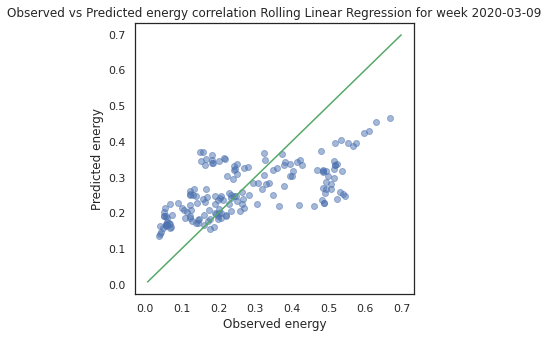

Root Mean Squared Error (RMSE): 0.12736
Mean Absolute Error (MAE): 0.10420
Finished forecasting week 2020-03-09 in 0:00:00.536734

Starting Linear Regression for week 2020-05-18 for week 2020-05-18...



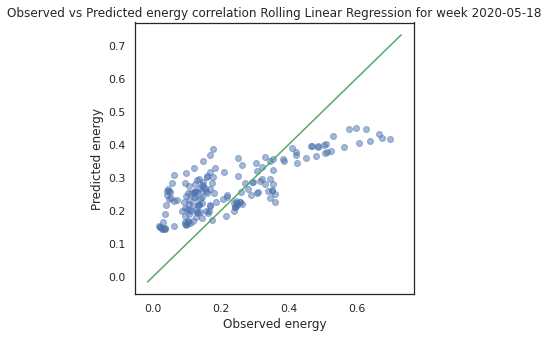

Root Mean Squared Error (RMSE): 0.11803
Mean Absolute Error (MAE): 0.10046
Finished forecasting week 2020-05-18 in 0:00:00.445522

Starting Linear Regression for week 2020-07-20 for week 2020-07-20...



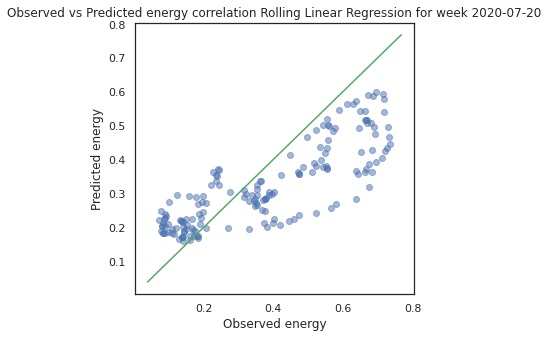

Root Mean Squared Error (RMSE): 0.14434
Mean Absolute Error (MAE): 0.11843
Finished forecasting week 2020-07-20 in 0:00:00.664629

Starting Linear Regression for week 2020-10-12 for week 2020-10-12...



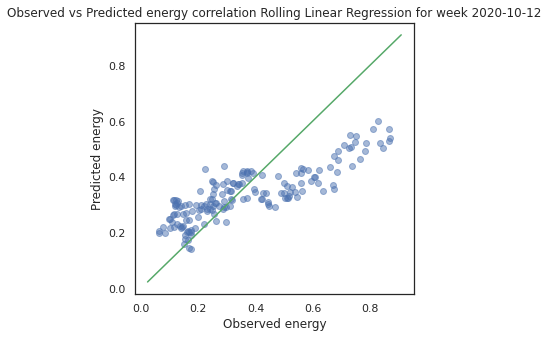

Root Mean Squared Error (RMSE): 0.14727
Mean Absolute Error (MAE): 0.12083
Finished forecasting week 2020-10-12 in 0:00:00.448813

Starting Linear Regression for week 2020-12-14 for week 2020-12-14...



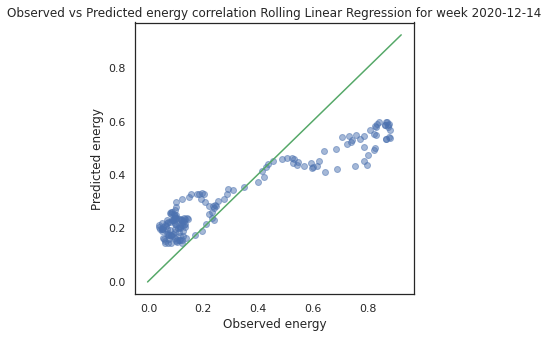

Root Mean Squared Error (RMSE): 0.16322
Mean Absolute Error (MAE): 0.13646
Finished forecasting week 2020-12-14 in 0:00:00.452148


In [9]:
for date in target_dates:
   # Load training data
   wind_energy_path = os.path.join('data', 'energy_data', str(date))
   train_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_train.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   train_data.loc[:, 'time'] = train_data.time.dt.tz_convert('CET')
   train_data.set_index('time', inplace=True)

   # Load testing data
   test_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_test.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   test_data.loc[:, 'time'] = test_data.time.dt.tz_convert('CET')
   test_data.set_index('time', inplace=True)

   days_in_test = sorted(set([date.date() for date in test_data.index]))
   rolling_eval.set_data(train_data, test_data)
   
   # Prediction
   clf_linreg = LinearRegression()
   rolling_pred_df = rolling_eval.rolling_prediction(days_in_test, 
                                                      clf_linreg, 
                                                      'Linear Regression for week %s' % str(date), 
                                                      'Wind energy (MW)', 
                                                      eval=True,
                                                      metrics=False,
                                                      plot=False)


### 2.2 Ridge Regression


Starting Ridge Regression for week 2020-03-09 for week 2020-03-09...



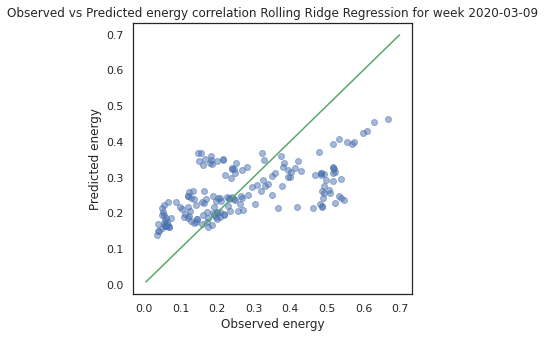

Root Mean Squared Error (RMSE): 0.13091
Mean Absolute Error (MAE): 0.10658
Finished forecasting week 2020-03-09 in 0:00:09.045440

Starting Ridge Regression for week 2020-05-18 for week 2020-05-18...



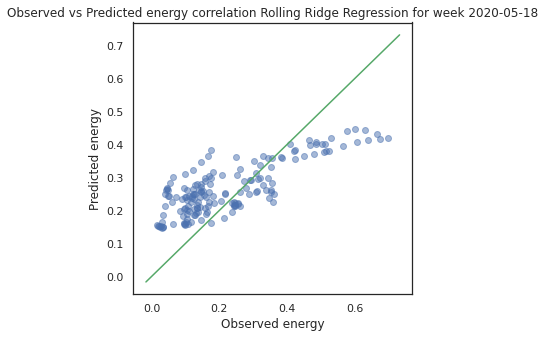

Root Mean Squared Error (RMSE): 0.11608
Mean Absolute Error (MAE): 0.09826
Finished forecasting week 2020-05-18 in 0:00:05.454479

Starting Ridge Regression for week 2020-07-20 for week 2020-07-20...



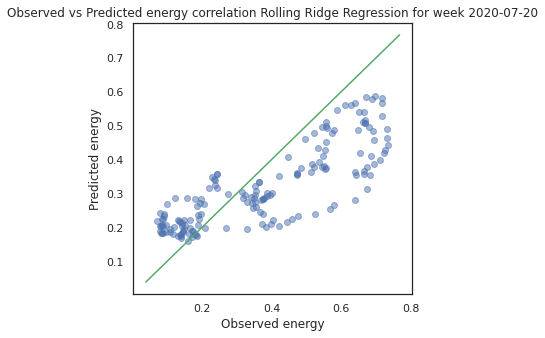

Root Mean Squared Error (RMSE): 0.14644
Mean Absolute Error (MAE): 0.12013
Finished forecasting week 2020-07-20 in 0:00:05.874358

Starting Ridge Regression for week 2020-10-12 for week 2020-10-12...



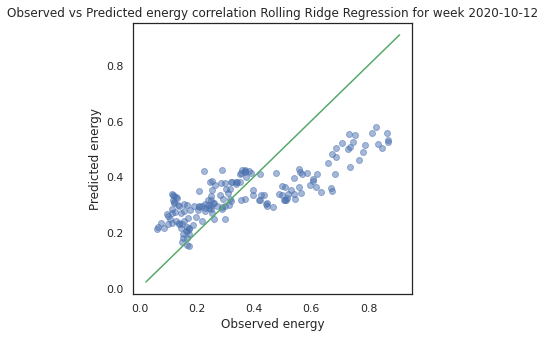

Root Mean Squared Error (RMSE): 0.15182
Mean Absolute Error (MAE): 0.12510
Finished forecasting week 2020-10-12 in 0:00:05.990236

Starting Ridge Regression for week 2020-12-14 for week 2020-12-14...



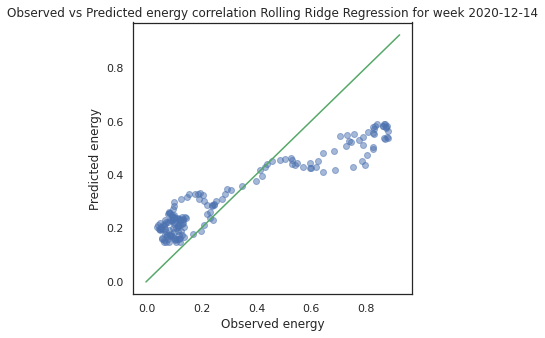

Root Mean Squared Error (RMSE): 0.16443
Mean Absolute Error (MAE): 0.13798
Finished forecasting week 2020-12-14 in 0:00:06.097939


In [10]:
for date in target_dates:
   # Load training data
   wind_energy_path = os.path.join('data', 'energy_data', str(date))
   train_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_train.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   train_data.loc[:, 'time'] = train_data.time.dt.tz_convert('CET')
   train_data.set_index('time', inplace=True)

   # Load testing data
   test_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_test.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   test_data.loc[:, 'time'] = test_data.time.dt.tz_convert('CET')
   test_data.set_index('time', inplace=True)

   days_in_test = sorted(set([date.date() for date in test_data.index]))
   rolling_eval.set_data(train_data, test_data)
   
   alpha_space = np.logspace(-3, 0, 20)
   param_grid = {'alpha': alpha_space}
   # for time-series cross-validation set 5 folds
   tscv = TimeSeriesSplit(n_splits=5)

   clf_ridge = GridSearchCV(Ridge(normalize = True),
                                 param_grid,
                                 cv = tscv,
                                 n_jobs = -1)
   
   # Prediction
   rolling_pred_df = rolling_eval.rolling_prediction(days_in_test, 
                                                      clf_ridge, 
                                                      'Ridge Regression for week %s' % str(date), 
                                                      'Wind energy (MW)', 
                                                      eval=True,
                                                      metrics=False,
                                                      plot=False)


### 2.3 Elastic Net Regression


Starting Elastic Net Regression for week 2020-03-09 for week 2020-03-09...



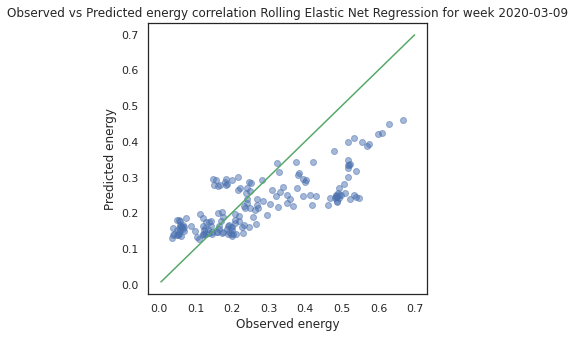

Root Mean Squared Error (RMSE): 0.12406
Mean Absolute Error (MAE): 0.09809
Finished forecasting week 2020-03-09 in 0:00:05.960713

Starting Elastic Net Regression for week 2020-05-18 for week 2020-05-18...



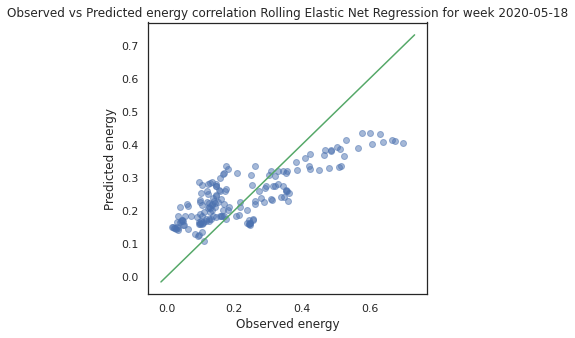

Root Mean Squared Error (RMSE): 0.10593
Mean Absolute Error (MAE): 0.09152
Finished forecasting week 2020-05-18 in 0:00:07.608326

Starting Elastic Net Regression for week 2020-07-20 for week 2020-07-20...



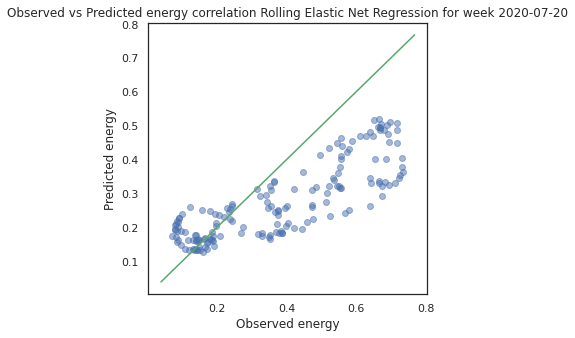

Root Mean Squared Error (RMSE): 0.17123
Mean Absolute Error (MAE): 0.13577
Finished forecasting week 2020-07-20 in 0:00:07.464879

Starting Elastic Net Regression for week 2020-10-12 for week 2020-10-12...



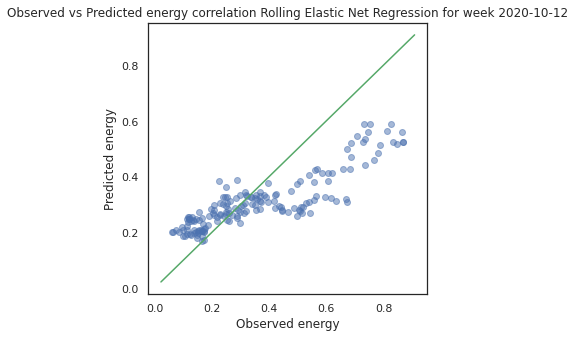

Root Mean Squared Error (RMSE): 0.14658
Mean Absolute Error (MAE): 0.11495
Finished forecasting week 2020-10-12 in 0:00:04.411561

Starting Elastic Net Regression for week 2020-12-14 for week 2020-12-14...



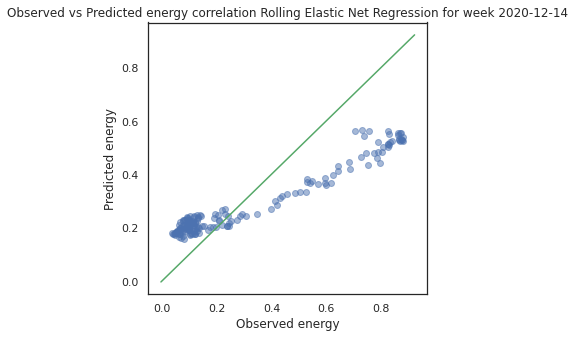

Root Mean Squared Error (RMSE): 0.17423
Mean Absolute Error (MAE): 0.14712
Finished forecasting week 2020-12-14 in 0:00:12.901822


In [11]:
for date in target_dates:
   # Load training data
   wind_energy_path = os.path.join('data', 'energy_data', str(date))
   train_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_train.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   train_data.loc[:, 'time'] = train_data.time.dt.tz_convert('CET')
   train_data.set_index('time', inplace=True)

   # Load testing data
   test_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_test.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   test_data.loc[:, 'time'] = test_data.time.dt.tz_convert('CET')
   test_data.set_index('time', inplace=True)

   days_in_test = sorted(set([date.date() for date in test_data.index]))
   rolling_eval.set_data(train_data, test_data)
   
   # Tuning parameters
   l1_space = np.linspace(0, 1, 30)
   alpha_space = np.logspace(-2, 0, 10)
   param_grid = {'l1_ratio': l1_space, 'alpha': alpha_space}
   # for time-series cross-validation set 5 folds
   tscv = TimeSeriesSplit(n_splits=5)

   clf_elnet = RandomizedSearchCV(ElasticNet(),
                                 param_grid,
                                 cv = tscv,
                                 n_jobs = -1)
   rolling_pred_df = rolling_eval.rolling_prediction(days_in_test, 
                                                      clf_elnet, 
                                                      'Elastic Net Regression for week %s' % str(date), 
                                                      'Wind energy (MW)', 
                                                      eval=True,
                                                      metrics=False,
                                                      plot=False)


### 2.4 Random Forest Regression


Starting Random Forest Regression for week 2020-03-09 for week 2020-03-09...



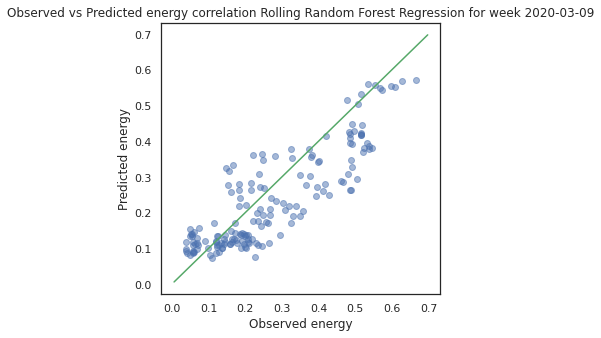

Root Mean Squared Error (RMSE): 0.09024
Mean Absolute Error (MAE): 0.07470
Finished forecasting week 2020-03-09 in 0:16:53.818321

Starting Random Forest Regression for week 2020-05-18 for week 2020-05-18...



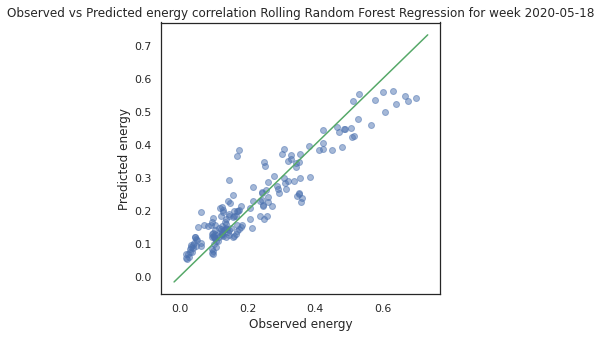

Root Mean Squared Error (RMSE): 0.05893
Mean Absolute Error (MAE): 0.04555
Finished forecasting week 2020-05-18 in 0:15:30.109498

Starting Random Forest Regression for week 2020-07-20 for week 2020-07-20...



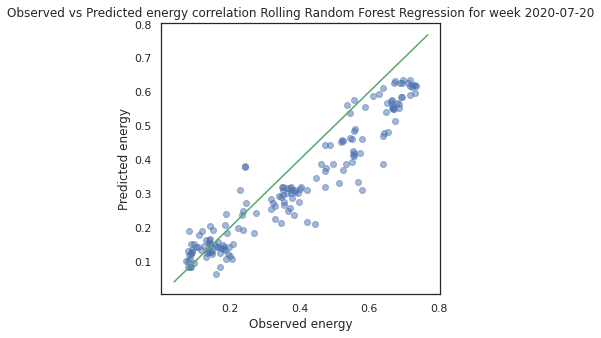

Root Mean Squared Error (RMSE): 0.09180
Mean Absolute Error (MAE): 0.07512
Finished forecasting week 2020-07-20 in 0:17:58.590393

Starting Random Forest Regression for week 2020-10-12 for week 2020-10-12...



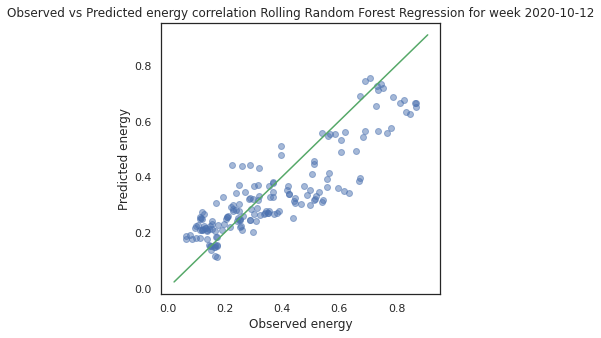

Root Mean Squared Error (RMSE): 0.11229
Mean Absolute Error (MAE): 0.08919
Finished forecasting week 2020-10-12 in 0:19:31.604967

Starting Random Forest Regression for week 2020-12-14 for week 2020-12-14...



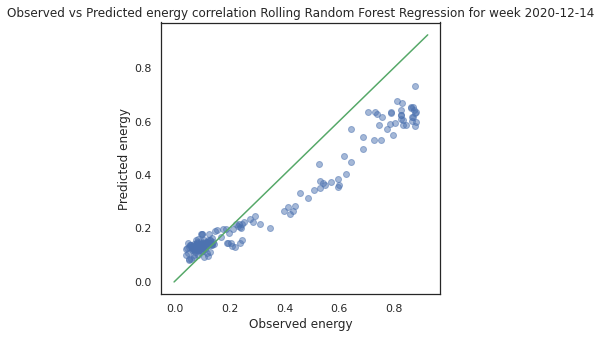

Root Mean Squared Error (RMSE): 0.12080
Mean Absolute Error (MAE): 0.09157
Finished forecasting week 2020-12-14 in 0:17:43.865468


In [12]:
for date in target_dates:
   # Load training data
   wind_energy_path = os.path.join('data', 'energy_data', str(date))
   train_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_train.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   train_data.loc[:, 'time'] = train_data.time.dt.tz_convert('CET')
   train_data.set_index('time', inplace=True)

   # Load testing data
   test_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_test.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   test_data.loc[:, 'time'] = test_data.time.dt.tz_convert('CET')
   test_data.set_index('time', inplace=True)

   days_in_test = sorted(set([date.date() for date in test_data.index]))
   rolling_eval.set_data(train_data, test_data)
   
   # Tuning parameters
   n_estimators = [int(x) for x in np.linspace(10, 200, 10, endpoint=True)]
   max_features = ['auto', 'sqrt']
   # Create the random grid
   param_grid = {'n_estimators': n_estimators, 
                 'max_features': max_features}
   # for time-series cross-validation set 5 folds
   tscv = TimeSeriesSplit(n_splits=5)

   clf_rf = RandomizedSearchCV(estimator = RandomForestRegressor(), 
                             param_distributions = param_grid,
                             scoring='neg_mean_squared_error',
                             cv = tscv,
                             verbose=0,
                             n_jobs = -1)
   rolling_pred_df = rolling_eval.rolling_prediction(days_in_test, 
                                                      clf_rf, 
                                                      'Random Forest Regression for week %s' % str(date), 
                                                      'Wind energy (MW)', 
                                                      eval=True,
                                                      metrics=False,
                                                      plot=False)


### 2.5 Extreme Gradient Boost


Starting Extreme Gradient Boost for week 2020-03-09 for week 2020-03-09...



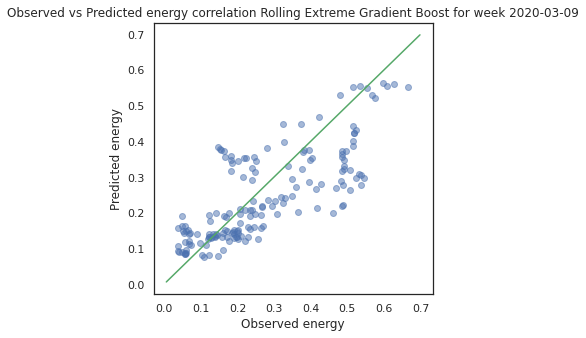

Root Mean Squared Error (RMSE): 0.10743
Mean Absolute Error (MAE): 0.08468
Finished forecasting week 2020-03-09 in 0:04:13.664515

Starting Extreme Gradient Boost for week 2020-05-18 for week 2020-05-18...



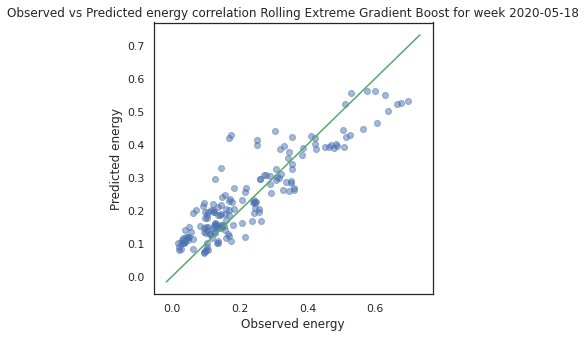

Root Mean Squared Error (RMSE): 0.07342
Mean Absolute Error (MAE): 0.05824
Finished forecasting week 2020-05-18 in 0:04:28.370890

Starting Extreme Gradient Boost for week 2020-07-20 for week 2020-07-20...



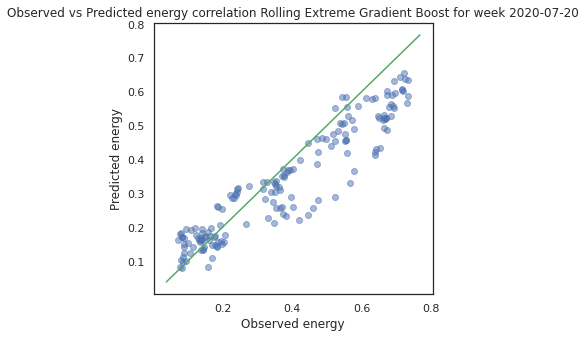

Root Mean Squared Error (RMSE): 0.09175
Mean Absolute Error (MAE): 0.07153
Finished forecasting week 2020-07-20 in 0:04:46.937166

Starting Extreme Gradient Boost for week 2020-10-12 for week 2020-10-12...



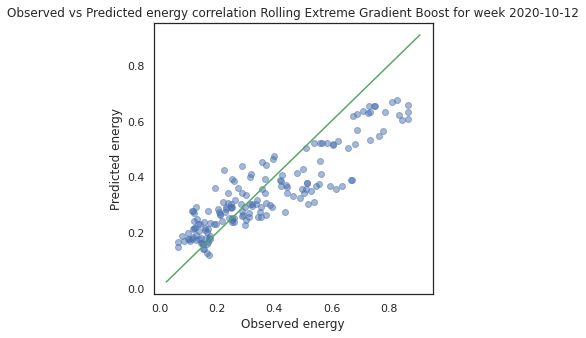

Root Mean Squared Error (RMSE): 0.11068
Mean Absolute Error (MAE): 0.08867
Finished forecasting week 2020-10-12 in 0:05:06.654694

Starting Extreme Gradient Boost for week 2020-12-14 for week 2020-12-14...



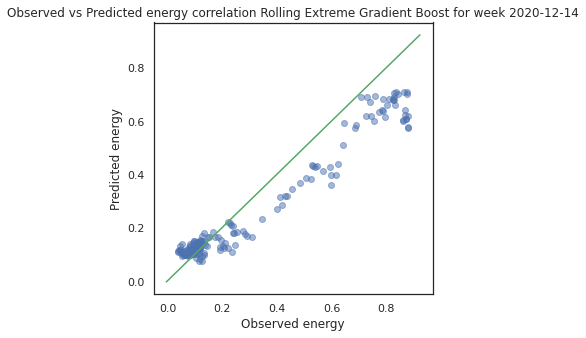

Root Mean Squared Error (RMSE): 0.10403
Mean Absolute Error (MAE): 0.07768
Finished forecasting week 2020-12-14 in 0:05:24.898114


In [13]:
for date in target_dates:
   # Load training data
   wind_energy_path = os.path.join('data', 'energy_data', str(date))
   train_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_train.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   train_data.loc[:, 'time'] = train_data.time.dt.tz_convert('CET')
   train_data.set_index('time', inplace=True)

   # Load testing data
   test_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_test.csv'), 
                            parse_dates=['time'], 
                            date_parser=lambda col: pd.to_datetime(col, utc=True),)
   test_data.loc[:, 'time'] = test_data.time.dt.tz_convert('CET')
   test_data.set_index('time', inplace=True)

   days_in_test = sorted(set([date.date() for date in test_data.index]))
   rolling_eval.set_data(train_data, test_data)
   
   # Tuning parameters
   param_grid = {
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200]}

   # for time-series cross-validation set 5 folds
   tscv = TimeSeriesSplit(n_splits=5)

   clf_xgb = RandomizedSearchCV(xgb.XGBRegressor(),
                                param_distributions=param_grid,
                                scoring='neg_mean_squared_error',
                                n_iter=20,
                                n_jobs=-1, 
                                cv=tscv,
                                verbose=0,
                                random_state=42)
   
   rolling_pred_df = rolling_eval.rolling_prediction(days_in_test, 
                                                      clf_xgb, 
                                                      'Extreme Gradient Boost for week %s' % str(date), 
                                                      'Wind energy (MW)', 
                                                      eval=True,
                                                      metrics=False,
                                                      plot=False)


### 2.6 Facebook Prophet

FBProphet provides a decomposition regression model that is extendable and configurable with interpretable parameters. Prophet frames the forecasting problem as a curve-fitting exercise rather than looking explicitly at the time based dependence of each observation within a time series. Similar to SARIMAX, we can add extra regressor terms like temperature data to the model as well.

At its core, the Prophet procedure is an additive regression model with four main components:

* A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
* A yearly seasonal component modeled using Fourier series.
* A weekly seasonal component using dummy variables.
* A user-provided list of important holidays.

In the solar energy production forecast experiment, the following seasonalities are explored:
* daily
* weekly
* yearly
* winter/summer seasonality

The **wind speed, gust and last day's solar energy generation** are added as external regressors.


Starting FB Prophet for week 2020-03-09 for week 2020-03-09...



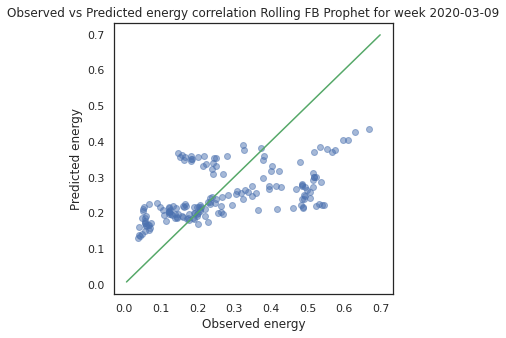

Root Mean Squared Error (RMSE): 0.13802
Mean Absolute Error (MAE): 0.11151
Finished forecasting week 2020-03-09 in 0:03:14.051398

Starting FB Prophet for week 2020-05-18 for week 2020-05-18...



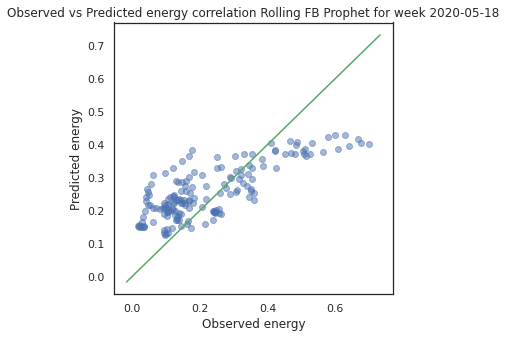

Root Mean Squared Error (RMSE): 0.11338
Mean Absolute Error (MAE): 0.09499
Finished forecasting week 2020-05-18 in 0:03:06.351177

Starting FB Prophet for week 2020-07-20 for week 2020-07-20...



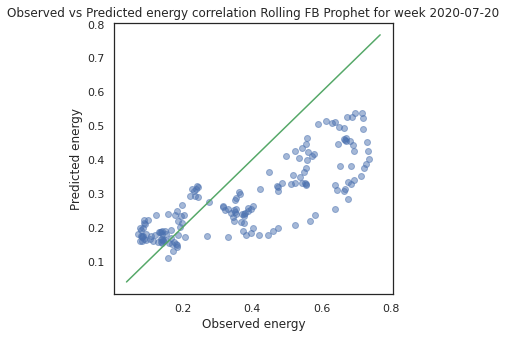

Root Mean Squared Error (RMSE): 0.16822
Mean Absolute Error (MAE): 0.13683
Finished forecasting week 2020-07-20 in 0:03:34.745877

Starting FB Prophet for week 2020-10-12 for week 2020-10-12...



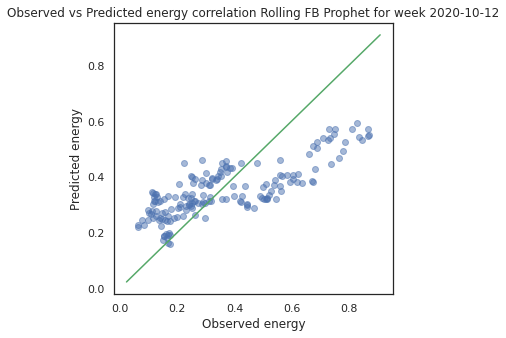

Root Mean Squared Error (RMSE): 0.15079
Mean Absolute Error (MAE): 0.12846
Finished forecasting week 2020-10-12 in 0:04:11.627615

Starting FB Prophet for week 2020-12-14 for week 2020-12-14...



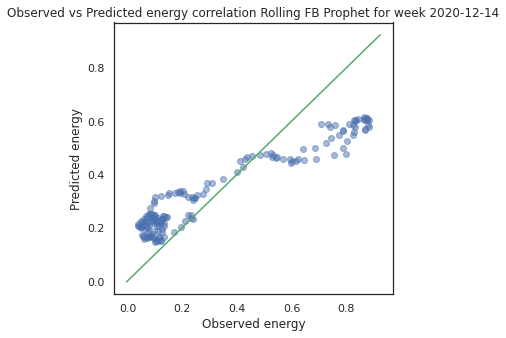

Root Mean Squared Error (RMSE): 0.15496
Mean Absolute Error (MAE): 0.13468
Finished forecasting week 2020-12-14 in 0:04:07.255138


In [14]:
for date in target_dates:
   # Load training data
   wind_energy_path = os.path.join('data', 'energy_data', str(date))
   train_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_train.csv'), 
                           parse_dates=['time'], 
                           date_parser=lambda col: pd.to_datetime(col, utc=True),)
   train_data.loc[:, 'time'] = train_data.time.dt.tz_convert('CET')
   train_data.rename(columns = {'Wind energy (MW)':'y', 'time':'ds'}, inplace=True)

   # Load testing data
   test_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_test.csv'), 
                           parse_dates=['time'], 
                           date_parser=lambda col: pd.to_datetime(col, utc=True),)
   test_data.loc[:, 'time'] = test_data.time.dt.tz_convert('CET')
   test_data.rename(columns = {'Wind energy (MW)':'y', 'time':'ds'}, inplace=True)

   days_in_test = sorted(set(test_data['ds'].dt.date.values))
   rolling_eval.set_data(train_data, test_data)

   rolling_pred_df = rolling_eval.pfProphet_prediction(days_in_test, 
                                                         ['windSpeed', 'gust', 'lagged_energy'],
                                                         'FB Prophet for week %s' % str(date), 
                                                         eval=True, 
                                                         metrics=False, 
                                                         plot=False)

### 2.6 Hybrid Models

We combine the FB Prophet additive model with a non-linear regresson such as Random Forest and Extreme Gradient Boost. The proposed hybrid models will attemp to capture the linearity of the timeseries with the FB Prophet model and the residuals with the non-linear models.

We use the trend as captured by the FB Prophet and we extract it from the original data. We attempt to forecast the new detrended timeseries using the non-linear models.

#### 2.6.1 Hybrid model FB Prophet and Random Forest


Starting Hybrid FB Prophet and Random Forest for week 2020-03-09 for week 2020-03-09...



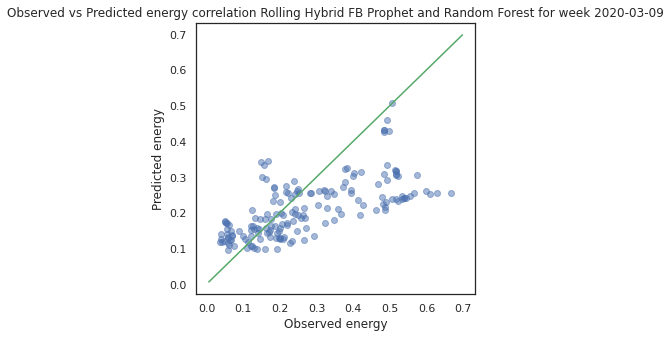

Root Mean Squared Error (RMSE): 0.13821
Mean Absolute Error (MAE): 0.10375
Finished forecasting week 2020-03-09 in 0:20:01.830955

Starting Hybrid FB Prophet and Random Forest for week 2020-05-18 for week 2020-05-18...



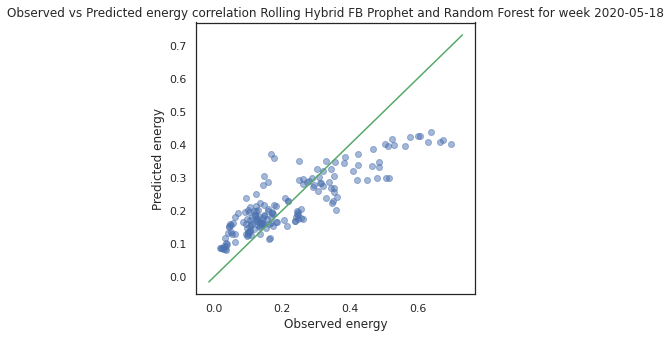

Root Mean Squared Error (RMSE): 0.09176
Mean Absolute Error (MAE): 0.07239
Finished forecasting week 2020-05-18 in 0:18:03.778970

Starting Hybrid FB Prophet and Random Forest for week 2020-07-20 for week 2020-07-20...



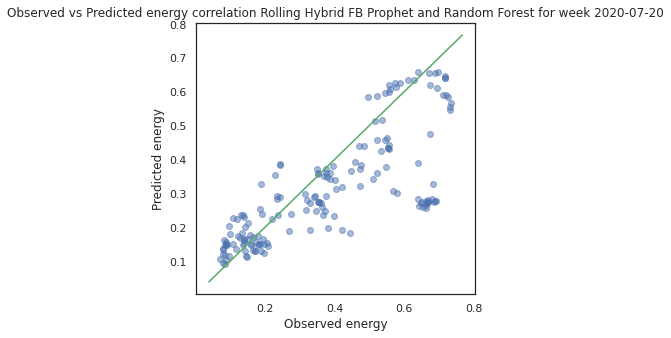

Root Mean Squared Error (RMSE): 0.15174
Mean Absolute Error (MAE): 0.10389
Finished forecasting week 2020-07-20 in 0:24:09.826993

Starting Hybrid FB Prophet and Random Forest for week 2020-10-12 for week 2020-10-12...



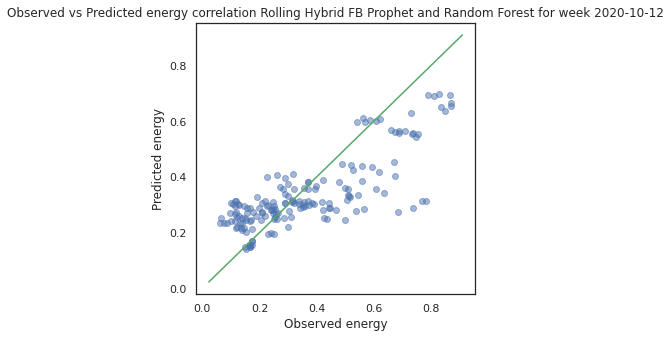

Root Mean Squared Error (RMSE): 0.13876
Mean Absolute Error (MAE): 0.10762
Finished forecasting week 2020-10-12 in 0:23:12.171511

Starting Hybrid FB Prophet and Random Forest for week 2020-12-14 for week 2020-12-14...



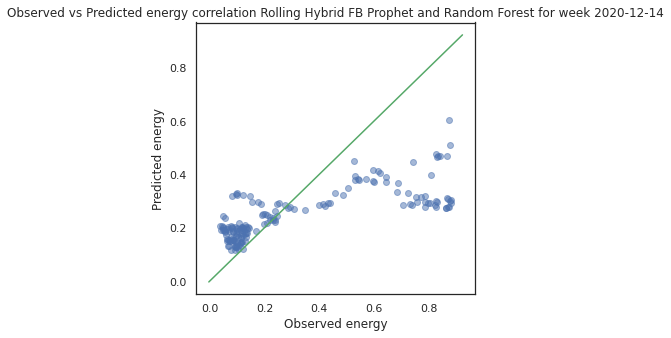

Root Mean Squared Error (RMSE): 0.24217
Mean Absolute Error (MAE): 0.17344
Finished forecasting week 2020-12-14 in 0:22:59.319296


In [15]:
for date in target_dates:
   # Load training data
   wind_energy_path = os.path.join('data', 'energy_data', str(date))
   train_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_train.csv'), 
                           parse_dates=['time'], 
                           date_parser=lambda col: pd.to_datetime(col, utc=True),)
   train_data.loc[:, 'time'] = train_data.time.dt.tz_convert('CET')
   train_data.rename(columns = {'Wind energy (MW)':'y', 'time':'ds'}, inplace=True)

   # Load testing data
   test_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_test.csv'), 
                           parse_dates=['time'], 
                           date_parser=lambda col: pd.to_datetime(col, utc=True),)
   test_data.loc[:, 'time'] = test_data.time.dt.tz_convert('CET')
   test_data.rename(columns = {'Wind energy (MW)':'y', 'time':'ds'}, inplace=True)

   days_in_test = sorted(set(test_data['ds'].dt.date.values))
   rolling_eval.set_data(train_data, test_data)
   
   # Tuning parameters
   n_estimators = [int(x) for x in np.linspace(10, 200, 10, endpoint=True)]
   max_features = ['auto', 'sqrt']
   # Create the random grid
   param_grid = {'n_estimators': n_estimators, 
                 'max_features': max_features}
   # for time-series cross-validation set 5 folds
   tscv = TimeSeriesSplit(n_splits=5)

   clf_rf = RandomizedSearchCV(estimator = RandomForestRegressor(), 
                             param_distributions = param_grid,
                             scoring='neg_mean_squared_error',
                             cv = tscv,
                             verbose=0,
                             n_jobs = -1)

   rolling_pred_df = rolling_eval.pfProphet_prediction(days_in_test, 
                                                         ['windSpeed', 'gust', 'lagged_energy'],
                                                         'Hybrid FB Prophet and Random Forest for week %s' % str(date), 
                                                         hybrid=True,
                                                         hybrid_model=clf_rf,
                                                         eval=True, 
                                                         metrics=False, 
                                                         plot=False)


#### 2.6.2 Hybrid model FB Prophet and Extreme Gradient Boost


Starting Hybrid FB Prophet and Extreme Gradient Boost for week 2020-03-09 for week 2020-03-09...



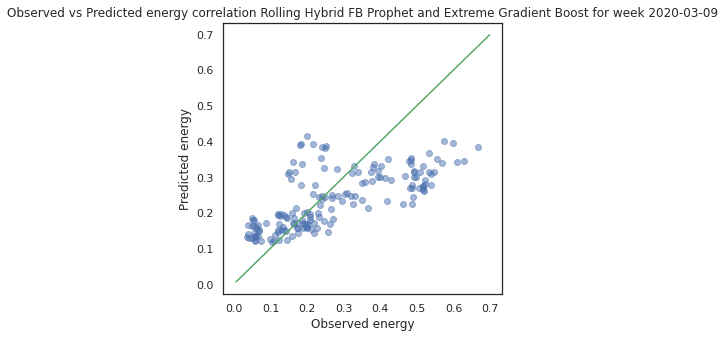

Root Mean Squared Error (RMSE): 0.12619
Mean Absolute Error (MAE): 0.09975
Finished forecasting week 2020-03-09 in 0:07:29.499052

Starting Hybrid FB Prophet and Extreme Gradient Boost for week 2020-05-18 for week 2020-05-18...



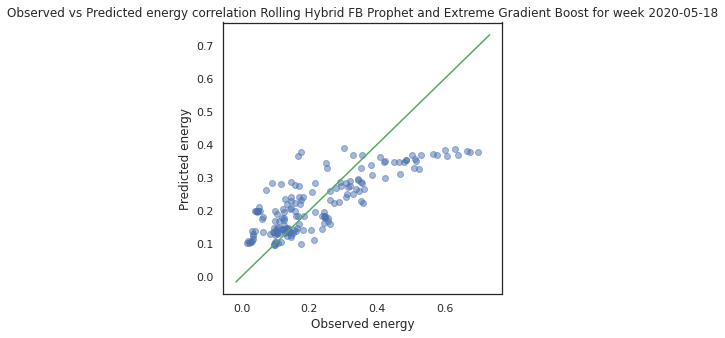

Root Mean Squared Error (RMSE): 0.10258
Mean Absolute Error (MAE): 0.07962
Finished forecasting week 2020-05-18 in 0:07:36.382675

Starting Hybrid FB Prophet and Extreme Gradient Boost for week 2020-07-20 for week 2020-07-20...



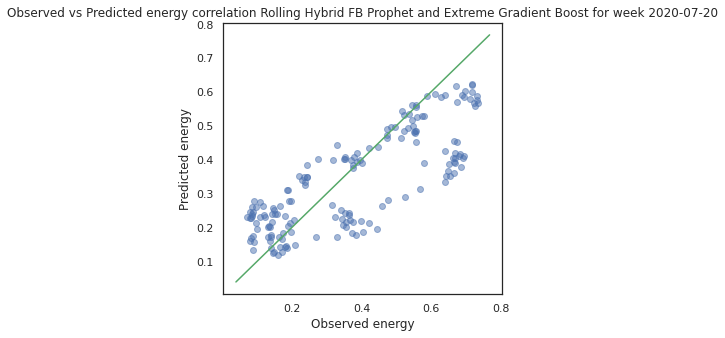

Root Mean Squared Error (RMSE): 0.13552
Mean Absolute Error (MAE): 0.10728
Finished forecasting week 2020-07-20 in 0:08:18.309072

Starting Hybrid FB Prophet and Extreme Gradient Boost for week 2020-10-12 for week 2020-10-12...



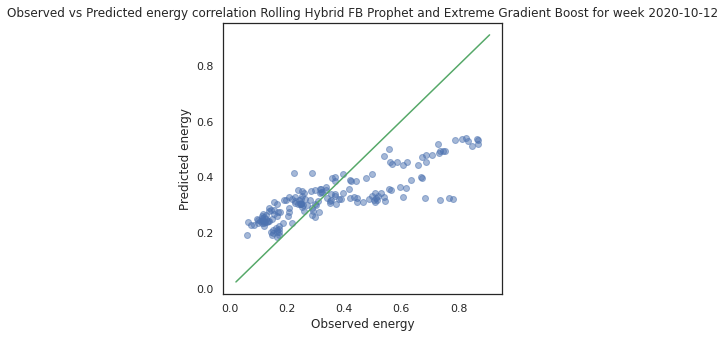

Root Mean Squared Error (RMSE): 0.15385
Mean Absolute Error (MAE): 0.12186
Finished forecasting week 2020-10-12 in 0:09:09.878190

Starting Hybrid FB Prophet and Extreme Gradient Boost for week 2020-12-14 for week 2020-12-14...



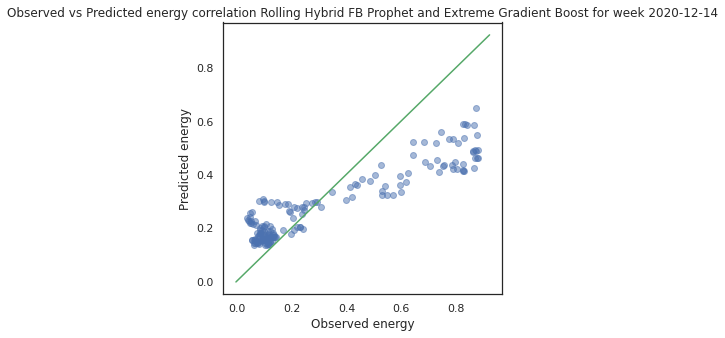

Root Mean Squared Error (RMSE): 0.18319
Mean Absolute Error (MAE): 0.14153
Finished forecasting week 2020-12-14 in 0:09:15.367034


In [16]:
for date in target_dates:
   # Load training data
   wind_energy_path = os.path.join('data', 'energy_data', str(date))
   train_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_train.csv'), 
                           parse_dates=['time'], 
                           date_parser=lambda col: pd.to_datetime(col, utc=True),)
   train_data.loc[:, 'time'] = train_data.time.dt.tz_convert('CET')
   train_data.rename(columns = {'Wind energy (MW)':'y', 'time':'ds'}, inplace=True)

   # Load testing data
   test_data = pd.read_csv(os.path.join(wind_energy_path, 'wind_test.csv'), 
                           parse_dates=['time'], 
                           date_parser=lambda col: pd.to_datetime(col, utc=True),)
   test_data.loc[:, 'time'] = test_data.time.dt.tz_convert('CET')
   test_data.rename(columns = {'Wind energy (MW)':'y', 'time':'ds'}, inplace=True)

   days_in_test = sorted(set(test_data['ds'].dt.date.values))
   rolling_eval.set_data(train_data, test_data)
   
   # Tuning parameters
   param_grid = {
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200]}

   # for time-series cross-validation set 5 folds
   tscv = TimeSeriesSplit(n_splits=5)

   clf_xgb = RandomizedSearchCV(xgb.XGBRegressor(),
                                param_distributions=param_grid,
                                scoring='neg_mean_squared_error',
                                n_iter=20,
                                n_jobs=-1, 
                                cv=tscv,
                                verbose=0,
                                random_state=42)

   rolling_pred_df = rolling_eval.pfProphet_prediction(days_in_test, 
                                                         ['windSpeed', 'gust', 'lagged_energy'],
                                                         'Hybrid FB Prophet and Extreme Gradient Boost for week %s' % str(date), 
                                                         hybrid=True,
                                                         hybrid_model=clf_xgb,
                                                         eval=True, 
                                                         metrics=False, 
                                                         plot=False)


## 3. Final Report

The final report, contains the evaluation of the main hypothesis using MAE and RMSE metrics as well as the violin plot of the error distribution, as error we define the absolute difference of the prediction and the expected value.

In [17]:
report_df = pd.DataFrame.from_dict(rolling_eval.model_comparison_dict).T
# report_df.drop(columns='diff', inplace=True)
report_df.loc[:, 'MAE'] = pd.to_numeric(report_df['MAE'])
report_df.loc[:, 'RMSE'] = pd.to_numeric(report_df['RMSE'])

model_list = list(set([k[:k.find('for')-1]
                       for k in set(list(rolling_eval.model_comparison_dict.keys()))]))

for date in target_dates:
   report_df.loc[report_df.index.str.contains(str(date)), 'week'] = date
   
for model in model_list:
   report_df.loc[report_df.index.str.contains(pat='^%s\s+for' % model), 'model'] = model.replace('Rolling ', '')


Below is the MAE and RMSE for each model and each week

In [18]:
for metric in ['MAE', 'RMSE']:
   fig = px.bar(report_df, x="week", y=metric, 
                      color="model", hover_name="model", 
                      barmode="group", title='%s Evaluation' % metric)
   fig.show()

Model performance averaged for all weeks

In [20]:
report_df.reset_index().groupby(by=['model']).mean().sort_values('RMSE')

MAE      RMSE
model                                                           
Random Forest Regression                      0.075226  0.094812
Extreme Gradient Boost                        0.076160  0.097462
Linear Regression                             0.116076  0.140044
Hybrid FB Prophet and Extreme Gradient Boost  0.110008  0.140266
Ridge Regression                              0.117610  0.141936
Elastic Net Regression                        0.117490  0.144406
FB Prophet                                    0.121294  0.145074
Hybrid FB Prophet and Random Forest           0.112218  0.152528

In [21]:
for metric in ['MAE', 'RMSE']:
   df = report_df.groupby(by=['model']).mean().reset_index().sort_values(metric).reset_index()

   fig = px.bar(df, x="model", y=metric, 
                color="model", hover_name="model", 
                title='Average %s of all test weeks' % (metric))
   fig.show()

Error distribution visualization using violin plot. The error distribution for each model and each week is presented

In [22]:
error_diff_df = pd.DataFrame.from_dict({k:rolling_eval.model_comparison_dict[k]['diff'] for k in rolling_eval.model_comparison_dict.keys()})

model_index = [c for col in [len(error_diff_df)*[col] for col in error_diff_df.columns] for c in col ]
diff = [a for array in [error_diff_df[col].values for col in error_diff_df.columns] for a in array]

report_diff_df = pd.DataFrame.from_dict({'model_index': model_index, 'error_diff': diff})

for date in target_dates:
   report_diff_df.loc[report_diff_df['model_index'].str.contains(str(date)), 'week'] = date
   
for model in model_list:
   report_diff_df.loc[report_diff_df['model_index'].str.contains(pat='^%s\s+for' % model), 'model'] = model.replace('Rolling ', '')


In [46]:
for week in report_diff_df['week'].unique():
   df = report_diff_df.loc[report_diff_df['week']==week]
   fig = px.violin(df, 
                   x="model",
                   y="error_diff", 
                   color='model', 
                   title='Boxplot of error distribution for week %s' % (week), 
                   box=True, # draw box plot inside the violin
                   points='outliers')
   fig.show()